In [72]:
# @title Access Key for Dataset {"run":"auto","vertical-output":true,"display-mode":"form"}
ACCESS_KEY = "AISTETIC" # @param {"type":"string"}


# **<span color="purple">TO DO: Hypothesis Tests</span>**


---


RQ1: Does a patient with `diabetes and an atrial rate of higher than 70 and a QRS duration of lower than 90 have lead to an abnormal ecg` diagnoses by medical professionals?


---


RQ2: Do former smokers with a `PR interval lower than 60 have a high incidence of diabetes`?

# **<span color="purple">TO DO: Feature Importance Tests</span>**


---


RQ1: Correlation of every feature to the diagnosis. Rank highly correlated ones.


# **<span color="purple">TO DO: Data & Models</span>**





---



```
Priorities: {
    RED: High
    YELLOW: Medium
    GREEN: Low
}
```




---





<span color="red"> 1.   Handle outliers better on the `WEIGHT` column by changing `SimpleImputer` to a `custom KNNImputer` using specific columns as neighbor features</span></br>
<span color="red">2. Convert problem into binary classification by forming an equivalence of `Borderline ECG ~ Abnormal ECG`, i.e, DIAGNOSIS = {`normal`, `abnormal`}</span></br>
<span color="yellow">3. Visualize more</span></br>
<span color="yellow">4. Try balancing the dataset either via undersampling or oversampling (using `SMOTE`) </span></br>
<span color="yellow">5. Perform `semi-supervised learning` to not drop the empty target rows</span></br>
<span color="green">6. Feature extract the `P, R, & T AXES` into a more valuable one. `This is low priority as I am currently unsure of what the value of these features are` </span></br>





# **<span color="purple">Imports</span>**

In [73]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, VotingClassifier)
from sklearn.experimental import enable_halving_search_cv
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, f1_score,
                             precision_score, precision_recall_curve,
                             roc_auc_score, roc_curve, recall_score)
from sklearn.model_selection import (HalvingGridSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler, OneHotEncoder,
                                   OrdinalEncoder, RobustScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# **<span color="purple">Configurations</span>**

In [74]:
plt.style.use('ggplot')
plt.rcParams["font.family"] = "STIXGeneral"

def set_global_determinism(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


DELIMITER = f'\n\n\n{"*" * 100}\n\n\n'
SEED = 42
FOLDS = 5

set_global_determinism(SEED)

In [75]:
def generate_fernet_key(key):
    import base64
    import hashlib


    return base64.urlsafe_b64encode(hashlib.sha256(key.encode()).digest())


def decrypt_link(encrypted_link, key):
    from cryptography.fernet import Fernet


    fernet_key = generate_fernet_key(key)
    cipher_suite = Fernet(fernet_key)
    decrypted_link = cipher_suite.decrypt(encrypted_link.encode())
    return decrypted_link.decode()


DS_LINK = "gAAAAABmyMWlt2tzS49oxCJv7Bvx_8c_KxZTSVrWVV1pPEfJ1YR3Fzeb6kkWb3ogTHOrggz-Xlksg1X_qikTKzaJjWCmuoIZaO7fIDaJchBba5FDwjJ2Imnf0_ZI6se_VvCiP8R8w4nntBIZKrNuf0cKqhIsekgGV_ZiP9wUJ1yD7YDz9d-UFb9C6bgVYvdtlj-C1Un4qEXm"
DS_LINK = decrypt_link(DS_LINK, ACCESS_KEY)
print(DS_LINK)

https://docs.google.com/spreadsheets/d/1RqVdHCqPMfKxDPrSHLgqdkVJPiGrbrqu/export?format=csv


# **<span color="purple">EDA</span>**

In [76]:
df = pd.read_csv(DS_LINK, na_values=['', ' ', 'NA', 'Invalid', 'Failed'], keep_default_na=False)

print(df.shape)
print(DELIMITER)
print(df.info())
print(DELIMITER)

nuisance_cols = [0, 1]
df.drop(df.columns[nuisance_cols], axis=1, inplace=True)
df.head()

(4466, 30)



****************************************************************************************************



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4466 entries, 0 to 4465
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MRN_ANON_ID              4466 non-null   object 
 1   ORDER_PROC_ID            4466 non-null   object 
 2   SEX                      4466 non-null   object 
 3   WEIGHT                   4437 non-null   float64
 4   DIABETES                 4466 non-null   object 
 5   SMOKE                    4466 non-null   object 
 6   VENTRICULAR RATE         4466 non-null   int64  
 7   ATRIAL RATE              4466 non-null   int64  
 8   P-R INTERVAL             4451 non-null   float64
 9   QRS DURATION             4466 non-null   int64  
 10  Q-T INTERVAL             4466 non-null   int64  
 11  QTC CALCULATION (BEZET)  4466 non-null   int64  
 12  P AXIS        

,SEX,WEIGHT,DIABETES,SMOKE,VENTRICULAR RATE,ATRIAL RATE,P-R INTERVAL,QRS DURATION,Q-T INTERVAL,QTC CALCULATION (BEZET),...,Diagnosis Line_5,Diagnosis Line_6,Diagnosis Line_7,Diagnosis Line_8,Diagnosis Line_9,Diagnosis Line_10,Diagnosis Line_11,Diagnosis Line_12,Diagnosis Line_13,Diagnosis Line_14
0,Male,204.59,Y,Former,74,74,266.0,88,438,486,...,VENTRICULAR RATE HAS DECREASED BY 3 BPM,"WHEN COMPARED WITH ECG OF 19-APR-2024 20:17,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Male,204.59,Y,Former,88,88,240.0,82,348,421,...,SINUS RHYTHM WITH FIRST DEGREE A-V BLOCK WITH ...,T WAVE INVERSION LESS EVIDENT IN LATERAL LEADS,"WHEN COMPARED WITH ECG OF 24-APR-2024 05:53,",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Male,204.59,Y,Former,77,77,232.0,80,396,448,...,SINUS RHYTHM WITH FIRST DEGREE A-V BLOCK WITH ...,"WHEN COMPARED WITH ECG OF 25-APR-2024 06:22,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Male,330.00,Y,Never,100,100,154.0,74,370,477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Male,162.48,N,Never,58,58,135.0,92,410,403,...,Sinus bradycardia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


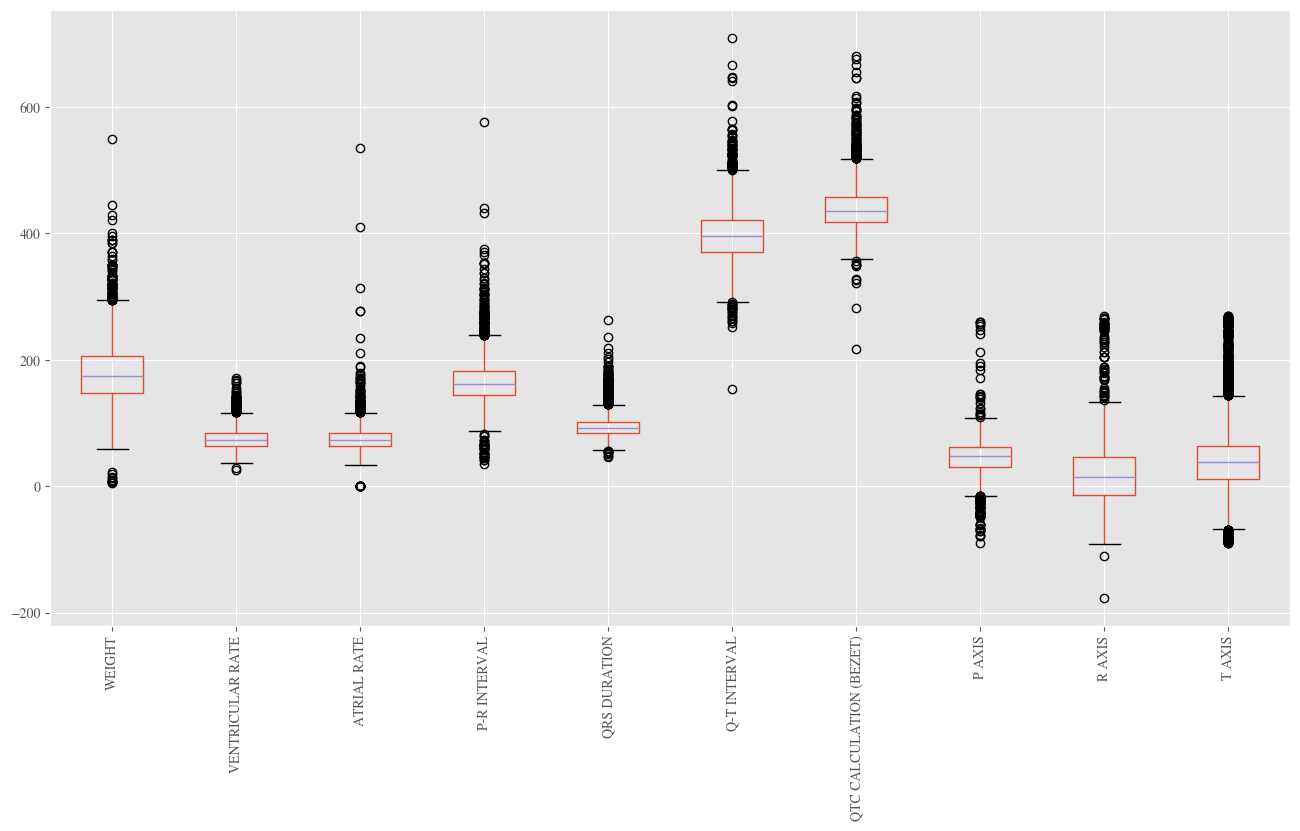

In [77]:
df.boxplot(figsize=(16,8))
plt.xticks(rotation=90)
plt.show()

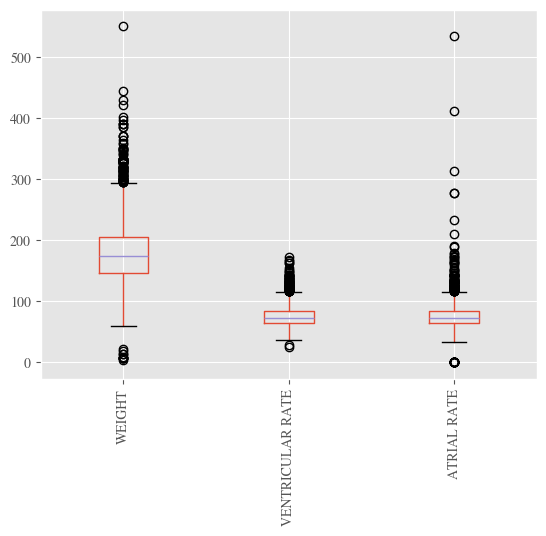

In [78]:
df[['WEIGHT', 'VENTRICULAR RATE', 'ATRIAL RATE']].boxplot()
plt.xticks(rotation=90)
plt.show()

# **<span color="purple">Preprocessing</span>**

In [79]:
def create_diagnosis_col(df):
    # Consolidate diagnosis columns
    diagnosis_cols = df.columns[13:]
    df['DIAGNOSIS'] = df[diagnosis_cols].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)
    df.drop(diagnosis_cols, axis=1, inplace=True)

    target_map = {
        'abnormal ecg': 1,
        'borderline ecg': 1,
        'normal ecg': 0
    }

    def encode_target(diagnosis):
        for key, value in target_map.items():
            if key in diagnosis.lower():  # case-insensitive matching
                return value
        return None  # Return None if no match is found

    df['DIAGNOSIS'] = df['DIAGNOSIS'].apply(encode_target)

    return df


def drop_missing_target_rows(df):
    """
    WARNING: This is a baseline and naive method. A better method
    (implemented in the future) would be to perform semi-supervised learning
    """
    df.dropna(subset=['DIAGNOSIS'], inplace=True)

    return df


def correct_smoker_col(df):
    # Smoker values = {Former, Never, Never Assessed, Some Days, Unknown,
    #                  (Smoker, Current Status Unknown), Every Day, Light Smoker,
    #                  Passive Smoke Exposure - Never Smoker, Heavy Smoker}
    # |Smoker| = 10: too much values and some label values are redundant

    categories = {
        'never': 0,
        'never assessed': 1,
        'unknown': 1,
        'former': 2,
        'smoker, current status unknown': 3,
        'light smoker': 3,
        'some days': 3,
        'passive smoke exposure - never smoker': 3,
        'every day': 4,
        'heavy smoker': 4
    }

    def encode_smoker(smoker):
        for key, value in categories.items():
            if key in smoker.lower():  # case-insensitive matching
                return value
        return None  # Return None if no match is found

    df['SMOKE'] = df['SMOKE'].apply(encode_smoker).astype('int64')

    return df

In [80]:
target_transformer = FunctionTransformer(create_diagnosis_col)
missing_transformer = FunctionTransformer(drop_missing_target_rows)

target_pipeline = Pipeline([
    ('target', target_transformer),
    ('missing', missing_transformer),
])

df = target_pipeline.fit_transform(df)
print(df.info())
print(DELIMITER)
df

<class 'pandas.core.frame.DataFrame'>
Index: 3986 entries, 0 to 4465
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEX                      3986 non-null   object 
 1   WEIGHT                   3969 non-null   float64
 2   DIABETES                 3986 non-null   object 
 3   SMOKE                    3986 non-null   object 
 4   VENTRICULAR RATE         3986 non-null   int64  
 5   ATRIAL RATE              3986 non-null   int64  
 6   P-R INTERVAL             3971 non-null   float64
 7   QRS DURATION             3986 non-null   int64  
 8   Q-T INTERVAL             3986 non-null   int64  
 9   QTC CALCULATION (BEZET)  3986 non-null   int64  
 10  P AXIS                   3970 non-null   float64
 11  R AXIS                   3986 non-null   int64  
 12  T AXIS                   3983 non-null   float64
 13  DIAGNOSIS                3986 non-null   float64
dtypes: float64(5), int64(6), obje

,SEX,WEIGHT,DIABETES,SMOKE,VENTRICULAR RATE,ATRIAL RATE,P-R INTERVAL,QRS DURATION,Q-T INTERVAL,QTC CALCULATION (BEZET),P AXIS,R AXIS,T AXIS,DIAGNOSIS
0,Male,204.59,Y,Former,74,74,266.0,88,438,486,37.0,-28,27.0,1.0
1,Male,204.59,Y,Former,88,88,240.0,82,348,421,66.0,-11,69.0,1.0
2,Male,204.59,Y,Former,77,77,232.0,80,396,448,32.0,-10,61.0,1.0
3,Male,330.00,Y,Never,100,100,154.0,74,370,477,67.0,64,69.0,0.0
4,Male,162.48,N,Never,58,58,135.0,92,410,403,45.0,28,29.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,Female,119.00,N,Never,75,62,172.0,146,432,482,49.0,-21,118.0,1.0
4461,Female,119.00,N,Never,71,71,178.0,144,454,493,57.0,-5,84.0,1.0
4463,Female,248.00,Y,Never,62,62,212.0,94,438,444,41.0,12,6.0,1.0
4464,Female,120.00,N,Former,72,72,182.0,100,400,438,87.0,-22,69.0,0.0


In [81]:
X = df.drop('DIAGNOSIS', axis=1)
y = df['DIAGNOSIS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

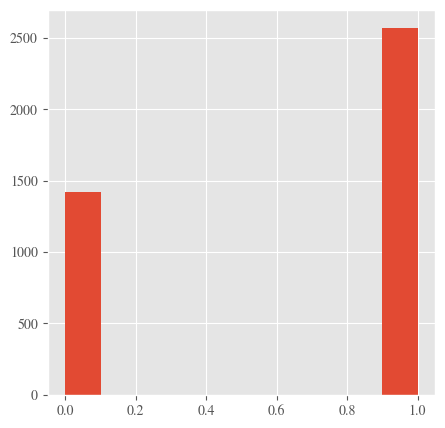




****************************************************************************************************



DIAGNOSIS
1.0    2567
0.0    1419
Name: count, dtype: int64



****************************************************************************************************



DIAGNOSIS
1.0    64.40%
0.0    35.60%
Name: count, dtype: object


In [82]:
y.hist(figsize=(5, 5))
plt.show()
print(DELIMITER)
value_counts = y.value_counts()
print(value_counts)
print(DELIMITER)
proportions = value_counts / len(y)
formatted_proportions = proportions.apply(lambda x: f'{x:.2%}')
print(formatted_proportions)

In [83]:
smoker_pipeline = make_pipeline(
    FunctionTransformer(correct_smoker_col),
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(),
)

heavytail_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    FunctionTransformer(np.log1p),
    RobustScaler(),
)

onehot_pipeline = make_pipeline(
    OneHotEncoder(sparse_output=False, dtype='int64'),
    SimpleImputer(strategy='most_frequent'),
)

ordinal_pipeline = make_pipeline(
    OrdinalEncoder(dtype='int64'),
    SimpleImputer(strategy='most_frequent'),
)

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    RobustScaler(),
)

preprocessing = ColumnTransformer([
    ('smoke', smoker_pipeline, ['SMOKE']),
    ('heavytail', heavytail_pipeline, ['P-R INTERVAL', 'QRS DURATION', 'Q-T INTERVAL', 'QTC CALCULATION (BEZET)']),
    ('onehot_encoder', onehot_pipeline, ['SEX']),
    ('ordinal_encoder', ordinal_pipeline, ['DIABETES']),
], remainder=numerical_pipeline)

X_train_transformed = preprocessing.fit_transform(X_train)

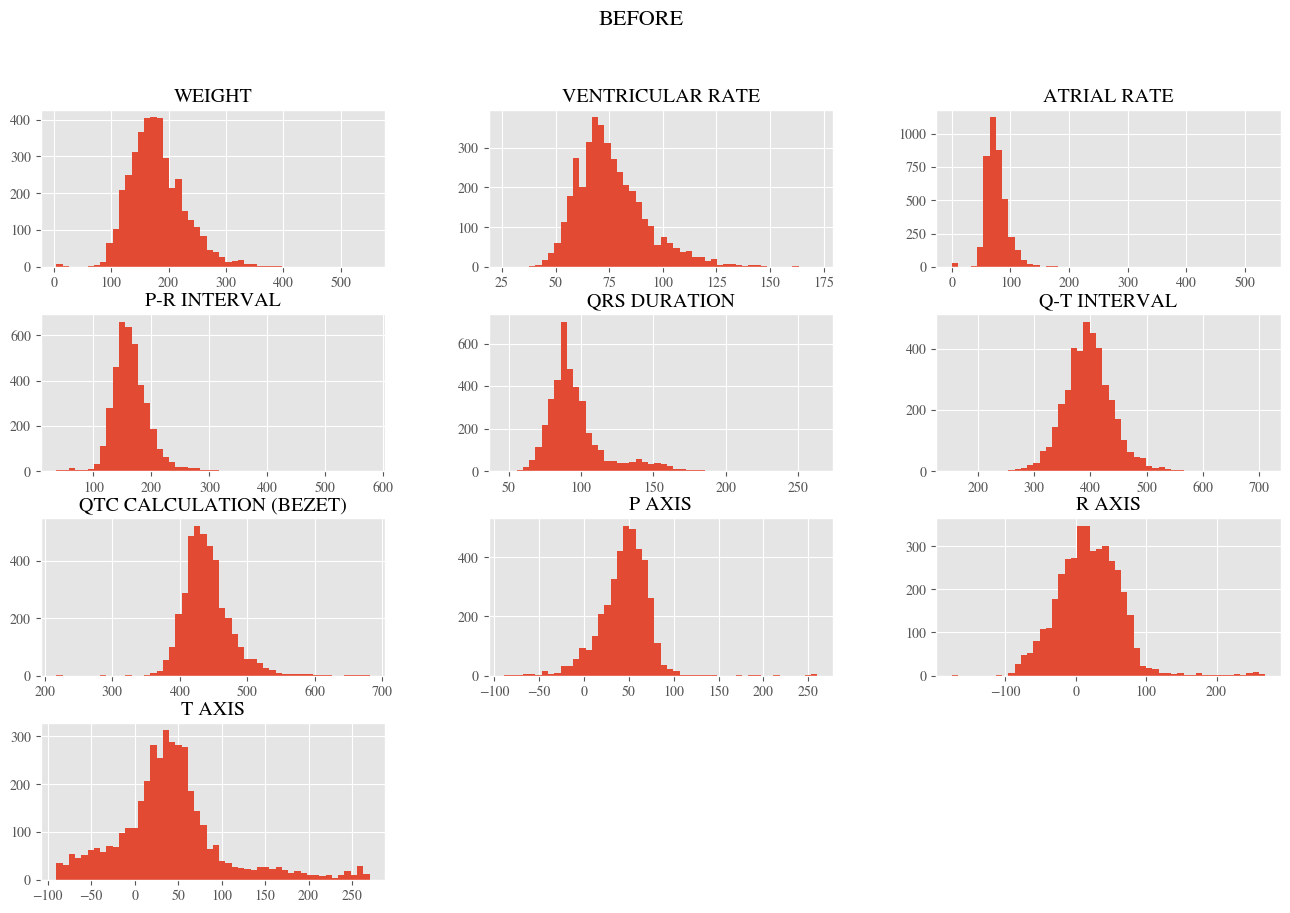

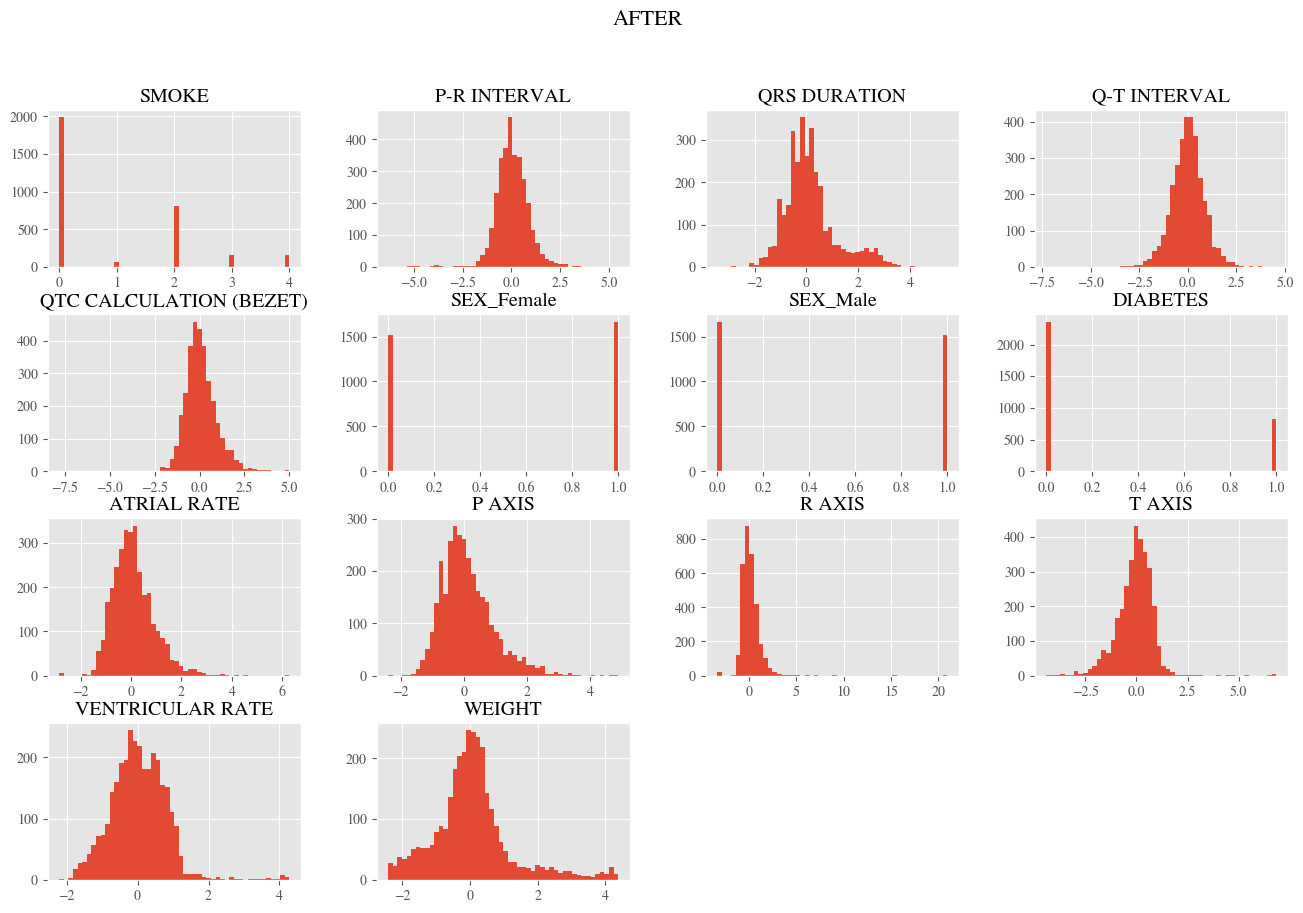

In [84]:
transformed_column_names = (
    ['SMOKE'] +
    ['P-R INTERVAL', 'QRS DURATION', 'Q-T INTERVAL', 'QTC CALCULATION (BEZET)'] +
    preprocessing.named_transformers_['onehot_encoder'].get_feature_names_out(['SEX']).tolist() +
    ['DIABETES'] +
    df.columns.difference(['SMOKE', 'P-R INTERVAL', 'QRS DURATION', 'Q-T INTERVAL', 'QTC CALCULATION (BEZET)', 'SEX', 'DIABETES', 'DIAGNOSIS']).tolist()
)

X.hist(bins=50, figsize=(16, 10))
plt.suptitle('BEFORE', fontsize=16)
plt.show()

pd.DataFrame(X_train_transformed, columns=transformed_column_names).hist(bins=50, figsize=(16, 10))
plt.suptitle('AFTER', fontsize=16)
plt.show()

# **<span color="purple">Model Validation & Selection</span>**

In [85]:
lgr_clf = LogisticRegression(random_state=SEED)
sgd_clf = SGDClassifier(random_state=SEED)
knn_clf = KNeighborsClassifier()
gnb_clf = GaussianNB()
svm_clf = SVC(random_state=SEED)
rft_clf = RandomForestClassifier(random_state=SEED)
ext_clf = ExtraTreesClassifier(random_state=SEED)
gbt_clf = GradientBoostingClassifier(random_state=SEED)

clfs = {
    'lgr': lgr_clf,
    'sgd': sgd_clf,
    'knn': knn_clf,
    'gnb': gnb_clf,
    'svm': svm_clf,
    'rft': rft_clf,
    'ext': ext_clf,
    'gbt': gbt_clf,
}

In [86]:
results = {clf_name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for clf_name in clfs}

stratified_kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for clf_name in clfs:
    print(f'Validating {clf_name.upper()}...')
    print(DELIMITER)
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        X_train_fold = preprocessing.fit_transform(X_train_fold)
        X_val_fold = preprocessing.transform(X_val_fold)

        clf = clfs[clf_name]
        clf.fit(X_train_fold, y_train_fold)

        y_pred = clf.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, y_pred)
        precision = precision_score(y_val_fold, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_val_fold, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val_fold, y_pred, average='weighted', zero_division=0)

        results[clf_name]['accuracy'].append(accuracy)
        results[clf_name]['precision'].append(precision)
        results[clf_name]['recall'].append(recall)
        results[clf_name]['f1'].append(f1)

Validating LGR...



****************************************************************************************************



Validating SGD...



****************************************************************************************************



Validating KNN...



****************************************************************************************************



Validating GNB...



****************************************************************************************************



Validating SVM...



****************************************************************************************************



Validating RFT...



****************************************************************************************************



Validating EXT...



****************************************************************************************************



Validating GBT...



****************************************************************************************************





In [87]:
average_val_res = {}

for clf_name, metrics in results.items():
    avg_metrics = {}
    for metric, scores in metrics.items():
        avg_score = sum(scores) / len(scores) if scores else 0
        avg_metrics[metric] = avg_score
    average_val_res[clf_name] = avg_metrics

print("Average Validation Results:\n\n")

for clf_name, metrics in average_val_res.items():
    print(f"Classifier: {clf_name.upper()}")
    print(f"  Validation Accuracy:   {metrics['accuracy'] * 100:.2f}%")
    print(f"  Validation Precision:  {metrics['precision'] * 100:.2f}%")
    print(f"  Validation Recall:     {metrics['recall'] * 100:.2f}%")
    print(f"  Validation F1-Score:   {metrics['f1'] * 100:.2f}%")
    print(DELIMITER)

Average Validation Results:


Classifier: LGR
  Validation Accuracy:   67.60%
  Validation Precision:  66.02%
  Validation Recall:     67.60%
  Validation F1-Score:   66.03%



****************************************************************************************************



Classifier: SGD
  Validation Accuracy:   65.68%
  Validation Precision:  64.04%
  Validation Recall:     65.68%
  Validation F1-Score:   64.17%



****************************************************************************************************



Classifier: KNN
  Validation Accuracy:   66.75%
  Validation Precision:  67.53%
  Validation Recall:     66.75%
  Validation F1-Score:   67.04%



****************************************************************************************************



Classifier: GNB
  Validation Accuracy:   67.25%
  Validation Precision:  73.27%
  Validation Recall:     67.25%
  Validation F1-Score:   67.91%



**********************************************************************

# **<span color="purple">Hyperparameter Tuning</span>**

In [88]:
def tune(model, hparams, model_name):
    search = HalvingGridSearchCV(model,
                                 hparams,
                                 n_jobs = -1,
                                 cv = FOLDS,
                                 refit = False,
                                 scoring = 'f1_weighted',
                                 random_state=SEED
                                )

    search.fit(X_train_transformed, y_train)

    best_hparams = search.best_params_

    print(f'{model_name.upper()} Best Hyperparameters: {best_hparams}')

    return best_hparams

In [89]:
tree_hparams = {'max_depth': [3, 5, 10, 15, 25, 50, None], 'min_samples_split':  [5, 10, 25, 50, 100]}
svm_hparams = {'C': [0.1, 1, 10, 20], 'kernel': ['linear', 'rbf']}
gnb_hparams = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

model_hparams = {
    'rft': tree_hparams,
    'ext': tree_hparams,
    'gbt': tree_hparams,
    'svm': svm_hparams,
    'gnb': gnb_hparams,
}

best_hparams = {
    'rft': '',
    'ext': '',
    'gbt': '',
    'svm': '',
    'gnb': '',
}

for clf_name, hparams in model_hparams.items():
    best = tune(clfs[clf_name], hparams, clf_name)
    best_hparams[clf_name] = best

RFT Best Hyperparameters: {'max_depth': 15, 'min_samples_split': 10}
EXT Best Hyperparameters: {'max_depth': 50, 'min_samples_split': 5}
GBT Best Hyperparameters: {'max_depth': 50, 'min_samples_split': 25}
SVM Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}
GNB Best Hyperparameters: {'var_smoothing': 1e-07}


# **<span color="purple">Model Evaluation</span>**

In [90]:
excluded_clfs = ['lgr', 'sgd', 'knn']
clfs = {clf_name: clfs[clf_name] for clf_name in clfs if clf_name not in excluded_clfs}

ens_clf = VotingClassifier(
    estimators=[
        ('rft', RandomForestClassifier(**best_hparams['rft'], random_state=SEED)),
        ('ext', ExtraTreesClassifier(**best_hparams['ext'], random_state=SEED)),
        ('gnb', GaussianNB(**best_hparams['gnb'])),
        ('gbt', GradientBoostingClassifier(**best_hparams['gbt'], random_state=SEED)),
        ('svm', SVC(**best_hparams['svm'], probability=True, random_state=SEED)),
    ],
    voting='soft',
)

clfs['ens'] = ens_clf

date_time = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f'{date_time}_ECG_results'
os.makedirs(results_dir, exist_ok=True)

best_f1_score = float('-inf')
best_model = None

trained_clfs = []

for clf_name in clfs:
    print(f'Evaluating {clf_name.upper()}')

    clf = clfs[clf_name]
    if clf_name != 'ens':
        clf.set_params(**best_hparams[clf_name])

    full_pipeline = make_pipeline(preprocessing, clf)
    full_pipeline.fit(X_train, y_train)
    y_pred = full_pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"  Testing Accuracy:   {accuracy * 100:.2f}%")
    print(f"  Testing Precision:  {precision * 100:.2f}%")
    print(f"  Testing Recall:     {recall * 100:.2f}%")
    print(f"  Testing F1-Score:   {f1 * 100:.2f}%")

    print(DELIMITER)

    filename = f'{clf_name}_{f1:.4f}.pkl'
    filepath = os.path.join(results_dir, filename)
    joblib.dump(full_pipeline, filepath)

    trained_clfs.append((clf_name, full_pipeline))

    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = full_pipeline


best_filename = f'best_{best_f1_score:.4f}.pkl'
best_filepath = os.path.join(results_dir, best_filename)
joblib.dump(best_model, best_filepath)

os.rename(results_dir, f'{best_f1_score * 100:.2f}%_{results_dir}')

Evaluating GNB
  Testing Accuracy:   68.80%
  Testing Precision:  73.38%
  Testing Recall:     68.80%
  Testing F1-Score:   69.34%



****************************************************************************************************



Evaluating SVM
  Testing Accuracy:   69.92%
  Testing Precision:  70.15%
  Testing Recall:     69.92%
  Testing F1-Score:   70.03%



****************************************************************************************************



Evaluating RFT
  Testing Accuracy:   69.55%
  Testing Precision:  68.90%
  Testing Recall:     69.55%
  Testing F1-Score:   69.09%



****************************************************************************************************



Evaluating EXT
  Testing Accuracy:   69.92%
  Testing Precision:  68.89%
  Testing Recall:     69.92%
  Testing F1-Score:   68.73%



****************************************************************************************************



Evaluating GBT
  Testing Accuracy:   70.30%
  Te

In [91]:
print(trained_clfs)

[('gnb', Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer()),
                                                             ('robustscaler',
                                                              RobustScaler())]),
                                   transformers=[('smoke',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function correct_smoker_col at 0x785078513eb0>)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal...
                                                  Pipeline(steps=[('one

In [92]:
trained_clfs = [clf for clf in trained_clfs if clf[0] != 'ens']

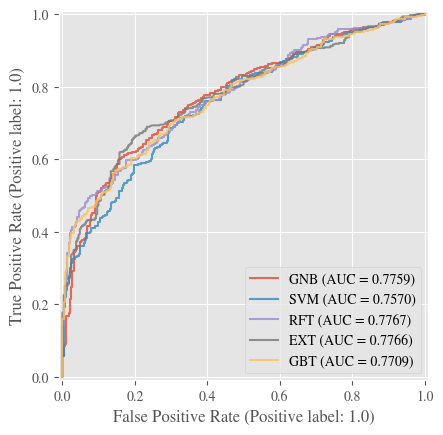

In [93]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for clf_name, clf in trained_clfs:
    display = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax, alpha=0.8, name=clf_name.upper())
    display.line_.set_label(f"{clf_name.upper()} (AUC = {display.roc_auc:.4f})")

plt.legend(loc="lower right")
plt.show()

In [94]:
ext_clf = trained_clfs[3][1]
ext_clf

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer()),
                                                             ('robustscaler',
                                                              RobustScaler())]),
                                   transformers=[('smoke',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function correct_smoker_col at 0x785078513eb0>)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal...
                                                                   OneHotEncoder(dtype='int64',
                                                                                 sparse_output=False)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['SEX']),
                                                 ('ordinal_encoder',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype='int64')),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['DIABETES'])])),
                ('extratreesclassifier',
                 ExtraTreesClassifier(max_depth=50, min_samples_split=5,
                                      random_state=42))])

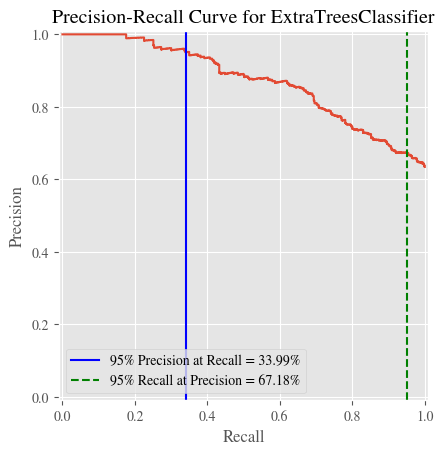

In [95]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

y_score = ext_clf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

precision_95_idx = np.argmin(np.abs(precision - 0.95))
recall_at_precision_95 = recall[precision_95_idx] * 100
threshold_at_precision_95 = thresholds[precision_95_idx]

recall_95_idx = np.argmin(np.abs(recall - 0.95))
precision_at_recall_95 = precision[recall_95_idx] * 100
threshold_at_recall_95 = thresholds[recall_95_idx]

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve for ExtraTreesClassifier")

plt.axvline(x=recall[precision_95_idx], color='blue', linestyle='-',
            label=f'95% Precision at Recall = {recall_at_precision_95:.2f}%')
plt.axvline(x=0.95, color='green', linestyle='--',
            label=f'95% Recall at Precision = {precision_at_recall_95:.2f}%')

plt.legend(loc="lower left")
plt.show()

13


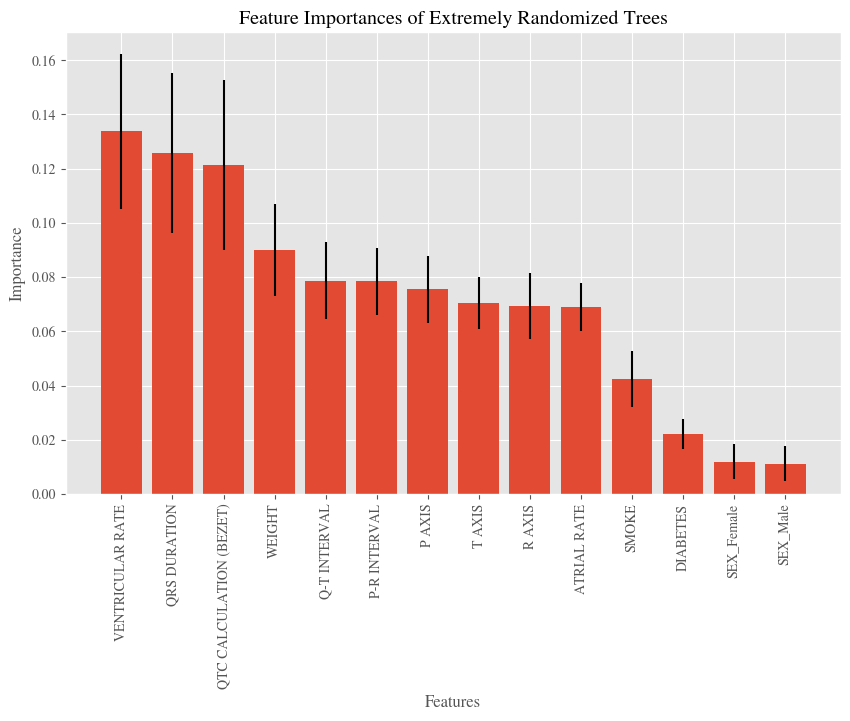

In [96]:
importances = ext_clf['extratreesclassifier'].feature_importances_
std = np.std([tree.feature_importances_ for tree in ext_clf[1].estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print(X.shape[1])

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1] + 1), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X.shape[1] + 1), [transformed_column_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances of Extremely Randomized Trees")
plt.show()